In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 30  # predict 30 days in the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(7))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0
5,2018-08-24,107.670,108.560,107.560,108.40,108.40,17234020,0.0,1.0
6,2018-08-23,107.150,108.180,106.870,107.56,107.56,18167723,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_adjusted_close"] = daily_adjusted_df["adjusted_close"].values.copy()
    else:
        processed_df["future_adjusted_close"] = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values.copy()
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_adjusted_close"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_adjusted_close"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
df = df.sample(frac=1)  # Shuffle df

display.display(df.describe())
display.display(df.head(7))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_adjusted_close
count,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,...,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5930.000000
mean,5.072053e-15,6.303820e-15,8.277284e-15,5.097216e-15,3.235186e-17,5.706509e-16,-9.885291e-18,3.594651e-18,1.838065e-15,2.396434e-18,...,-2.912866e-15,-4.643091e-17,-2.380857e-15,3.331044e-16,-2.863739e-15,-5.991085e-18,1.557682e-17,-8.986628e-18,9.893679e-15,26.760220
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,18.931413
min,-1.175037e+00,-1.166050e+00,-1.182378e+00,-1.315315e+00,-1.369035e+00,-7.782110e+00,-1.137025e+01,-4.317744e+00,-5.313835e+00,-3.662566e+01,...,-6.729928e+00,-6.461059e+00,-7.143444e+00,-6.911655e+00,-7.143444e+00,-3.175922e+00,-8.214181e+00,-8.971041e+00,-1.315315e+00,2.454300
25%,-8.169001e-01,-8.171005e-01,-8.146773e-01,-4.840935e-01,-6.709609e-01,-4.600725e-01,-7.224421e-01,-4.813023e-01,-5.577503e-01,-4.732978e-02,...,-7.327126e-01,-1.827355e-01,-4.702840e-01,-4.748390e-01,-4.702840e-01,-2.252368e-01,-4.776289e-01,-4.706525e-01,-4.840935e-01,17.552950
50%,-3.381844e-01,-3.390233e-01,-3.374561e-01,-2.672278e-01,-1.381068e-01,1.880375e-01,-3.782082e-02,-1.171538e-02,1.850690e-01,1.282417e-02,...,-2.514227e-02,-6.435620e-02,2.415049e-01,2.393940e-01,2.415049e-01,-3.235557e-02,8.471738e-03,1.841538e-02,-2.672278e-01,21.489650
75%,5.988323e-01,5.931731e-01,6.107239e-01,1.269919e-01,4.839479e-01,7.704783e-01,7.359585e-01,4.393195e-01,7.575758e-01,6.439506e-02,...,7.655157e-01,5.410997e-03,7.385192e-01,7.400710e-01,7.385192e-01,1.672982e-01,4.632927e-01,4.717511e-01,1.269919e-01,29.032775
max,3.634590e+00,3.604155e+00,3.615331e+00,4.400546e+00,1.798424e+01,1.259024e+00,6.147545e+00,7.321329e+00,1.373777e+00,1.827160e+01,...,2.469971e+00,8.430045e+00,1.314746e+00,1.301864e+00,1.314746e+00,1.244431e+01,9.325830e+00,8.576996e+00,4.400546e+00,112.330000


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_adjusted_close
2460,-1.092204,-1.047924,-1.089633,-0.596792,3.762220,0.389320,-3.022465,-1.628101,1.007340,-0.454935,...,0.828846,-0.098725,0.831123,0.815739,0.831123,0.064509,-2.434103,-2.488552,-0.596792,15.2925
2299,-0.918606,-0.910689,-0.914282,-0.376178,0.723977,-0.120317,1.245272,0.293760,0.627298,-0.022828,...,-0.586703,0.243729,0.719770,0.726411,0.719770,0.091120,0.332693,0.341995,-0.376178,19.7248
2062,-0.873665,-0.873630,-0.882372,-0.330610,1.402206,-0.352431,1.643367,0.605301,0.725499,0.204868,...,-0.073432,0.156174,0.816410,0.788887,0.816410,-0.108485,0.980849,0.982701,-0.330610,20.6879
3205,-0.808749,-0.814857,-0.804240,-0.301144,0.429849,-3.071680,1.072630,2.692260,-0.594161,0.019442,...,0.812625,0.119891,-0.100835,-0.035150,-0.100835,0.134051,0.130912,0.140858,-0.301144,19.7277
2285,-0.921250,-0.916190,-0.916369,-0.403842,0.355336,0.166494,1.028894,-0.572956,0.503466,0.055554,...,-1.591399,-0.109436,0.357842,0.358719,0.357842,-0.107841,0.772313,0.777450,-0.403842,20.2121
5374,1.712384,1.721957,1.751477,-0.933432,-1.152347,0.588680,-0.137800,0.102576,-1.554691,0.038538,...,-0.638701,-0.065788,-1.435932,-1.801612,-1.435932,-0.464084,-0.525587,-0.519161,-0.933432,10.2788
4803,0.895505,0.898839,0.890227,0.090834,-0.604720,-0.330588,0.465377,0.342690,-0.571847,0.030672,...,-0.348895,-0.057758,-1.737139,-1.758348,-1.737139,-0.606222,0.057535,0.067516,0.090834,31.2372


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,...,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000
mean,-0.004618,-0.004730,-0.004732,-0.007871,0.005600,-0.005628,0.005828,0.002870,-0.001160,-0.001618,...,0.004297,-0.000907,-0.003585,-0.001599,-0.000974,-0.001599,0.008002,-0.003356,-0.003431,-0.007871
std,1.002365,1.002018,1.002223,0.991313,1.007352,1.000677,1.004811,1.013141,1.000456,1.005376,...,1.002358,0.997453,0.984687,1.008729,1.007806,1.008729,1.003148,1.002586,1.003912,0.991313
min,-1.175037,-1.166050,-1.182378,-1.315315,-1.369035,-7.782110,-11.370252,-4.317744,-5.313835,-36.625661,...,-3.148711,-6.729928,-6.461059,-7.143444,-6.911655,-7.143444,-3.175922,-8.214181,-8.971041,-1.315315
25%,-0.818442,-0.820647,-0.815870,-0.484584,-0.665703,-0.463899,-0.722501,-0.485733,-0.553884,-0.047350,...,-0.700527,-0.737338,-0.183422,-0.466814,-0.470422,-0.466814,-0.220912,-0.476629,-0.469641,-0.484584
50%,-0.352577,-0.350459,-0.346179,-0.269795,-0.125502,0.180526,-0.038141,-0.011305,0.184616,0.012780,...,0.016856,-0.026016,-0.064138,0.244078,0.240116,0.244078,-0.029511,0.007270,0.017212,-0.269795
75%,0.574452,0.564438,0.583064,0.108452,0.489688,0.761533,0.747686,0.446961,0.756169,0.064030,...,0.701270,0.761826,0.005941,0.739417,0.740177,0.739417,0.170066,0.462302,0.470768,0.108452
max,3.634590,3.604155,3.615331,4.400546,17.984242,1.259024,6.147545,7.321329,1.373777,17.454917,...,3.377060,2.469971,8.430045,1.314746,1.301864,1.314746,12.444313,8.537078,7.906252,4.400546


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.041565,0.042569,0.042586,0.070843,-0.050396,0.050656,-0.052448,-0.025830,0.010438,0.014561,...,-0.038675,0.008167,0.032261,0.014389,0.008767,0.014389,-0.072019,0.030205,0.030875,0.070843
std,0.978305,0.981458,0.979571,1.073321,0.930505,0.993290,0.954829,0.873207,0.996665,0.950934,...,0.978501,1.023461,1.128925,0.918376,0.927543,0.918376,0.969056,0.976727,0.964353,1.073321
min,-1.133033,-1.120305,-1.135857,-1.315315,-1.338166,-4.397166,-4.048598,-3.653479,-3.497277,-5.033710,...,-2.594312,-4.982196,-3.272434,-3.777547,-3.881841,-3.777547,-2.754496,-4.763435,-5.001465,-1.315315
25%,-0.798174,-0.798643,-0.798275,-0.474692,-0.686780,-0.439016,-0.705981,-0.444431,-0.594211,-0.047047,...,-0.749727,-0.669877,-0.175019,-0.502510,-0.498743,-0.502510,-0.267462,-0.483391,-0.476478,-0.474692
50%,-0.253882,-0.254627,-0.247469,-0.239478,-0.209019,0.247699,0.003070,-0.015058,0.190357,0.013095,...,0.005970,-0.015717,-0.066502,0.224143,0.236697,0.224143,-0.062507,0.021947,0.031905,-0.239478
75%,0.735713,0.744812,0.756030,0.296213,0.458406,0.834256,0.653115,0.345765,0.779910,0.067986,...,0.667806,0.777038,0.000754,0.721417,0.731712,0.721417,0.132187,0.482704,0.491009,0.296213
max,3.239810,3.303629,3.272382,4.337244,5.510430,1.249021,2.392021,5.350945,1.373777,18.271598,...,2.894631,2.387579,8.430045,1.293176,1.288230,1.293176,10.135493,9.325830,8.576996,4.337244


Training targets summary:


count    5337.000000
mean       26.593273
std        18.770713
min         2.454300
25%        17.501500
50%        21.421100
75%        28.602400
max       112.330000
Name: future_adjusted_close, dtype: float64

Validation targets summary:


count    593.000000
mean      28.262738
std       20.275635
min        2.526200
25%       17.874000
50%       21.980400
75%       32.395400
max      112.020000
Name: future_adjusted_close, dtype: float64

In [7]:
display.display(validation_examples.head(7))
display.display(validation_targets.head(7))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
5043,1.547011,1.618886,1.576126,-0.439137,-0.813795,0.303129,0.342658,0.342385,-0.605747,-0.020170,...,1.744807,0.133464,-0.050029,-0.089285,-0.090357,-0.089285,0.706043,0.336020,0.345304,-0.439137
875,-0.426011,-0.417629,-0.414769,0.658312,0.509332,0.707927,-1.113143,0.240949,0.922542,-0.215971,...,0.797480,-0.893221,-0.600778,0.837395,0.883096,0.837395,-0.159899,-0.195957,-0.186682,0.658312
5940,0.144717,0.122623,0.130073,-1.315315,-1.279317,0.928862,-0.063274,-0.051541,-2.959864,0.013182,...,-0.891427,-1.896140,-0.064352,-2.535157,-2.604971,-2.535157,-0.634935,-0.299831,-0.291218,-1.315315
5606,1.859252,1.827054,1.900586,-1.180256,-1.338166,0.817429,0.034873,0.025761,-2.906287,0.012311,...,0.480465,-0.037039,-0.062350,-2.295483,-2.324978,-2.295483,-0.384881,0.558889,0.566519,-1.180256
1660,-0.756464,-0.763321,-0.755929,-0.091235,0.056268,0.320771,-0.847211,-1.148758,0.470643,0.061309,...,-0.944574,-0.374984,-0.516389,0.431751,0.531777,0.431751,-0.239067,-0.623568,-0.618414,-0.091235
1674,-0.812861,-0.802118,-0.804985,-0.143506,1.868124,-0.200872,1.916843,-1.088256,0.593813,0.276339,...,-0.093804,-1.289278,-0.214135,0.637357,0.624543,0.637357,-0.287613,0.683793,0.690071,-0.143506
2567,-0.790831,-0.795748,-0.797083,-0.250508,0.481060,-0.257566,1.102689,1.530015,0.726866,0.076063,...,1.707526,0.862010,0.409904,0.815141,0.827334,0.815141,0.278348,0.457305,0.465810,-0.250508


5043    18.0831
875     44.2670
5940     2.9472
5606     4.9291
1660    27.1148
1674    26.6070
2567    20.3271
Name: future_adjusted_close, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 3.92
  period 01 : 2.51
  period 02 : 2.02
  period 03 : 1.73
  period 04 : 1.56
  period 05 : 1.47
  period 06 : 1.37
  period 07 : 1.31
  period 08 : 1.27
  period 09 : 1.21
Model training finished.
Final RMSE (on training data):   1.21
Final RMSE (on validation data): 1.32


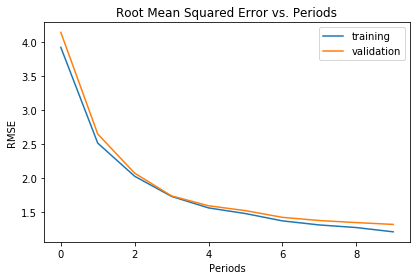

In [11]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
    steps=1000,
    batch_size=50,
    hidden_units=[30, 30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [12]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
display.display(predictions)

[115.224884,
 118.11716,
 117.47062,
 117.60487,
 117.24472,
 117.114815,
 116.75279,
 116.56799,
 116.21088,
 115.17659,
 114.93075,
 114.813515,
 114.61349,
 114.11317,
 112.82054,
 112.49494,
 112.60376,
 112.37763,
 112.34155,
 112.37058,
 111.779945,
 110.84769,
 108.37693,
 107.92564,
 109.15803,
 111.054016,
 110.9258,
 112.960945,
 111.37144,
 111.33531]